Set size = 50000
Training set size = 45000
Validation set size = 2500
Test set size = 2500
Epoch 1/5
1800/1800 [==============================] - 79s 43ms/step - loss: 0.6799 - val_loss: 0.4886
Epoch 2/5
1800/1800 [==============================] - 76s 42ms/step - loss: 0.5157 - val_loss: 0.4638
Epoch 3/5
1800/1800 [==============================] - 73s 41ms/step - loss: 0.4816 - val_loss: 0.4484
Epoch 4/5
1800/1800 [==============================] - 76s 42ms/step - loss: 0.4597 - val_loss: 0.4251
Epoch 5/5
1800/1800 [==============================] - 78s 43ms/step - loss: 0.4442 - val_loss: 0.4208
Saved trained model at ../output/NeuralNetwork/saved_models\aparent_loss_all_libs_no_sampleweights.h5 
[0.28657338 0.00678594 0.18490358 ... 0.9252748  0.03617646 1.1137689 ]


c:\Users\julia\AppData\Local\Programs\Python\python37\lib\site-packages\scipy\stats\stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
c:\Users\julia\kDrive\Fhnw\BachelorArbeit\Code\service\common\PlotHelper.py:38: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.axis([np.min(prediction), np.max(prediction), np.min(y_test), np.max(y_test)])


Epoch 1/5
1800/1800 [==============================] - 76s 42ms/step - loss: 0.0055 - dense_3_loss: 6.6897e-04 - dense_2_loss: 0.0049 - val_loss: 0.0049 - val_dense_3_loss: 5.8417e-07 - val_dense_2_loss: 0.0049
Epoch 2/5
1800/1800 [==============================] - 76s 42ms/step - loss: 0.0049 - dense_3_loss: 5.9110e-07 - dense_2_loss: 0.0049 - val_loss: 0.0049 - val_dense_3_loss: 3.9807e-07 - val_dense_2_loss: 0.0049
Epoch 3/5
1800/1800 [==============================] - 72s 40ms/step - loss: 0.0049 - dense_3_loss: 4.3022e-07 - dense_2_loss: 0.0049 - val_loss: 0.0049 - val_dense_3_loss: 2.9308e-07 - val_dense_2_loss: 0.0049
Epoch 4/5
1800/1800 [==============================] - 72s 40ms/step - loss: 0.0049 - dense_3_loss: 3.3080e-07 - dense_2_loss: 0.0049 - val_loss: 0.0049 - val_dense_3_loss: 2.2841e-07 - val_dense_2_loss: 0.0049
Saved trained model at ../output/NeuralNetwork/saved_models\aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5 


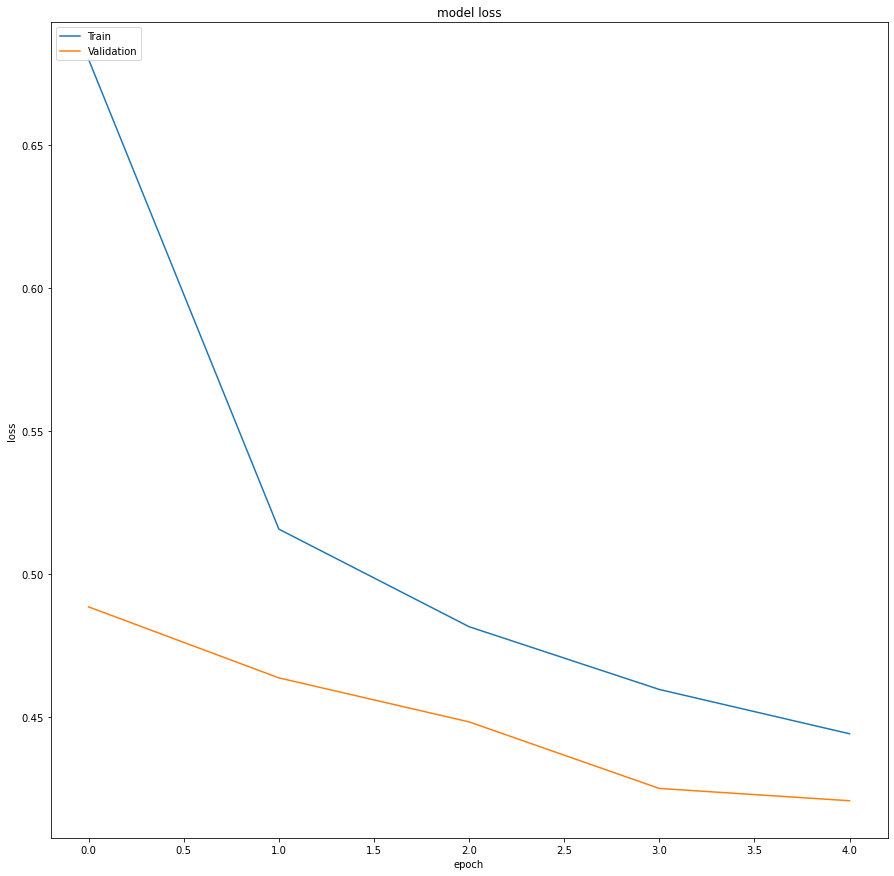

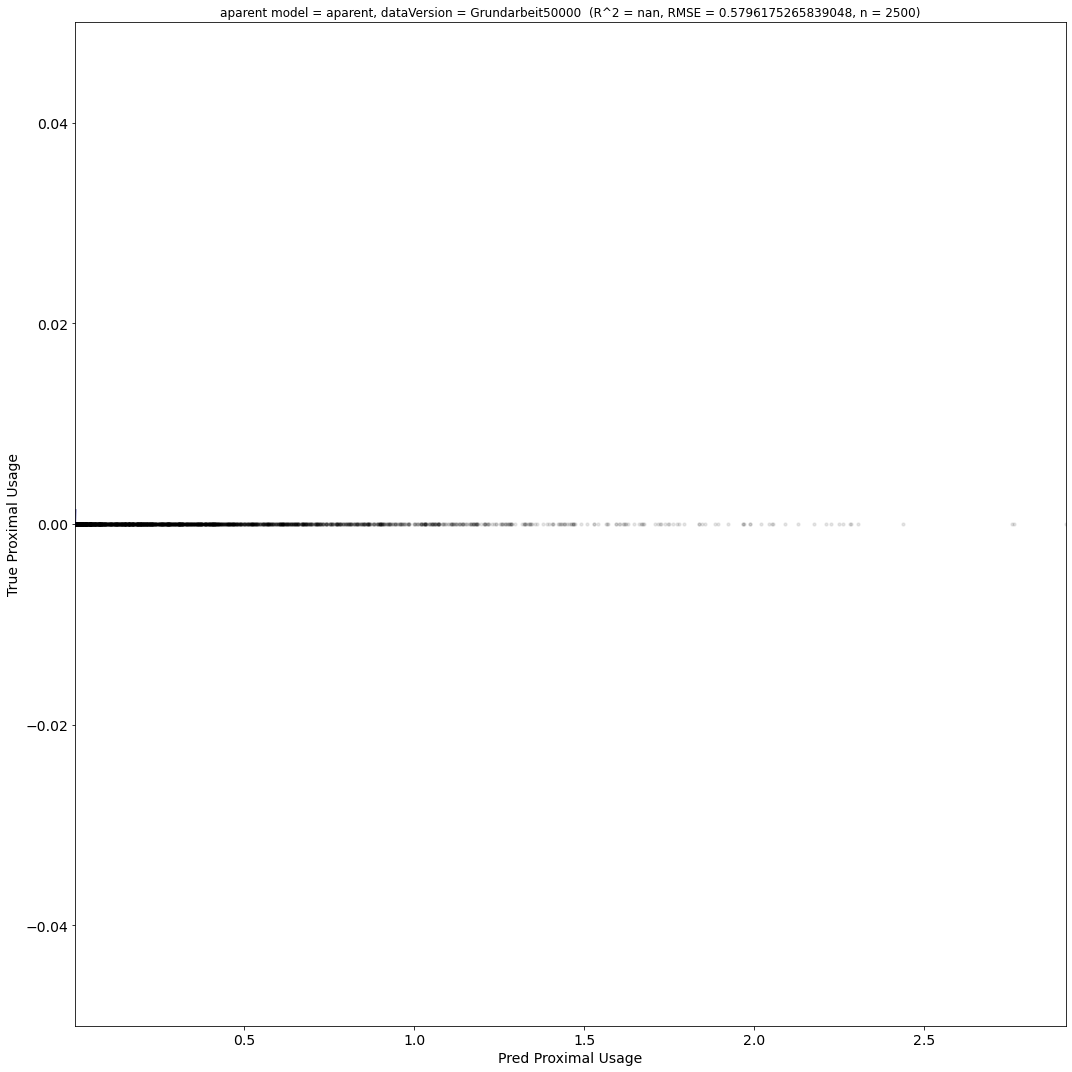

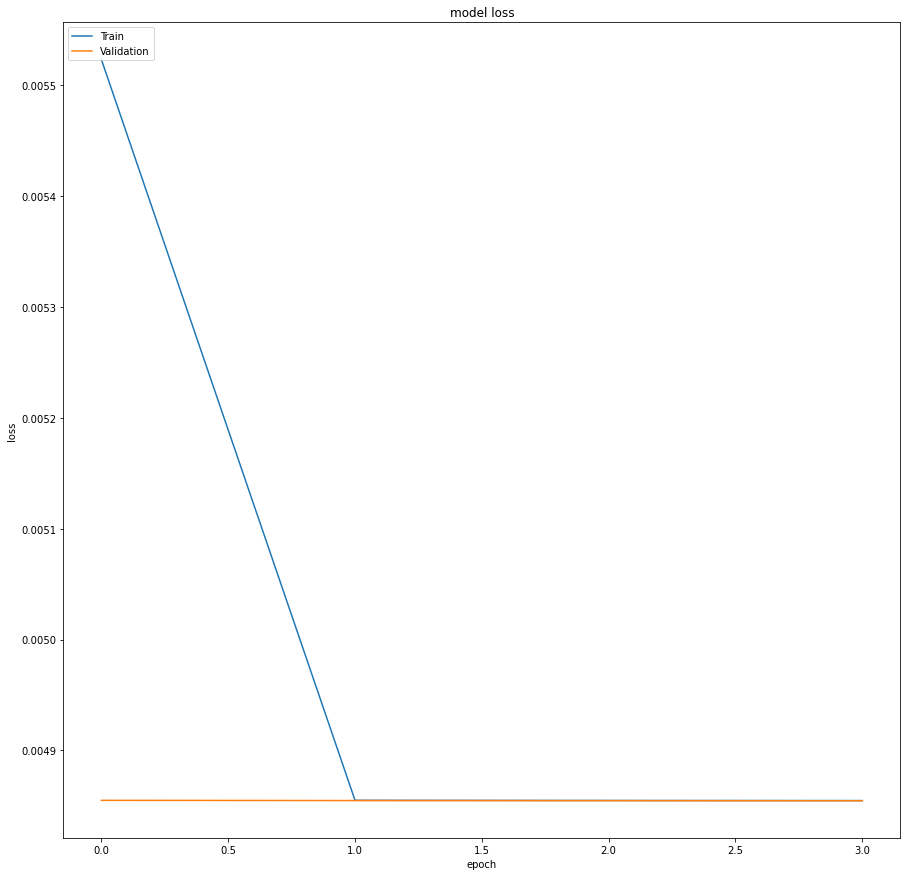

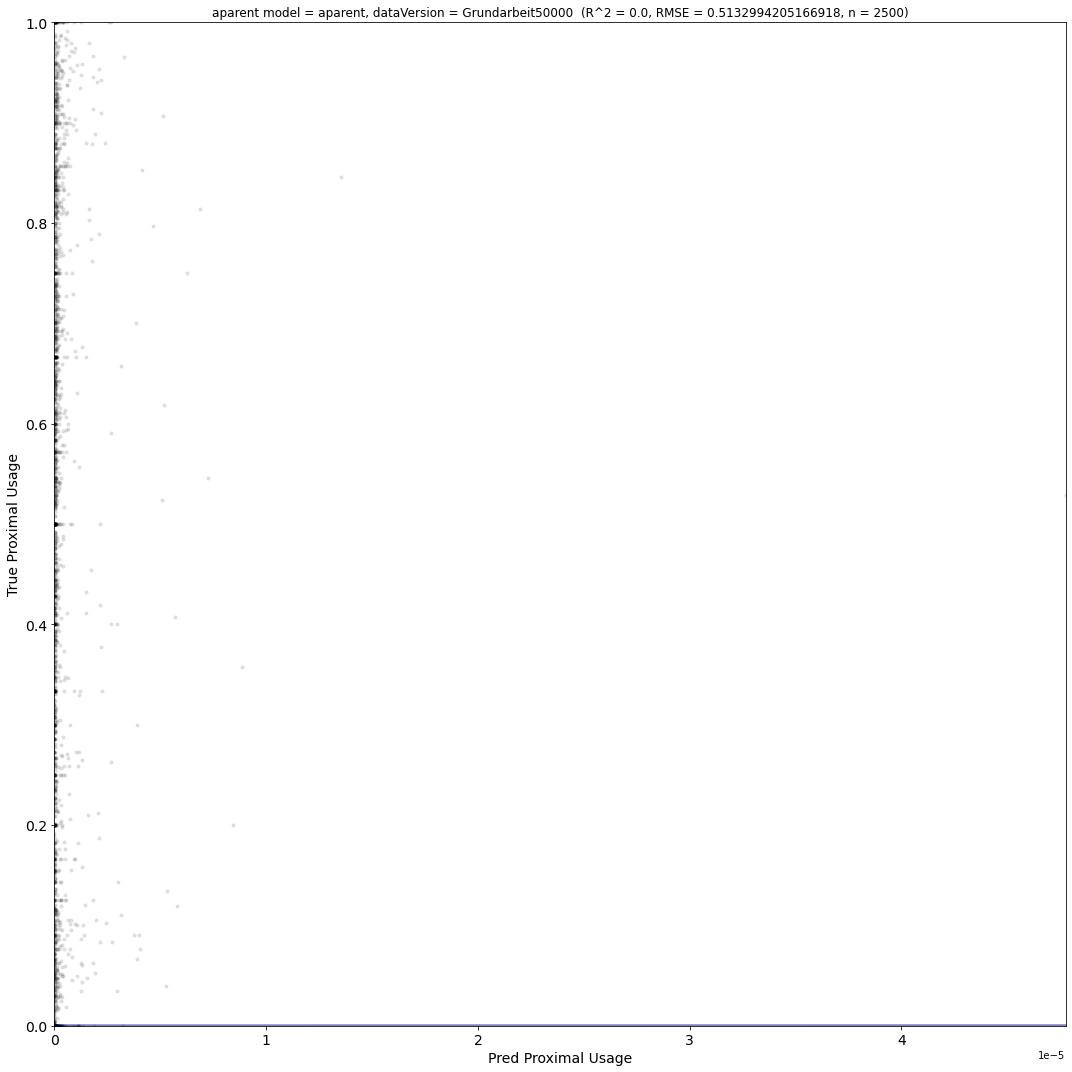

In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os
import numpy as np

from neuralNetwork.aparent_data_plasmid import load_data
from neuralNetwork.aparent_model_plasmid_large_lessdropout import load_aparent_model
from common.PlotHelper import plotLossfunctionPerEpochs, plotScatterWithAxis
from neuralNetwork.KerasModelHelper import trainModel, saveModel, loadModel

basePath = "../service"
outputPath = "../output/NeuralNetwork/"
dataPath = "../data/"
sampleSize = 50000

#Trainer parameters
save_dir_path = os.path.join(outputPath, 'saved_models')
load_name_suffix = 'all_libs_no_sampleweights'
save_name_suffix = 'all_libs_no_sampleweights'
epochs = 5 #15
batch_size = 25
use_sample_weights = False
data_version = 'Grundarbeit50000'
model_version = 'aparent'

valid_set_size = 0.05
test_set_size = 0.05

kept_libraries = None


data = load_data(batch_size=batch_size, file_path=dataPath, valid_set_size=valid_set_size, test_set_size=test_set_size, data_version='', kept_libraries=kept_libraries, sampleSize=sampleSize)
models = load_aparent_model(batch_size, use_sample_weights=use_sample_weights)
plasmid_model_prefix, plasmid_model = models[0]
loss_model_prefix, loss_model = models[1]
trainingData = data[0]
predictionData = data[1]
# predictionData = data

checkpoint_dir = os.path.join(outputPath, 'model_checkpoints')
if not os.path.isdir(checkpoint_dir):
    os.makedirs(checkpoint_dir)

opt = tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)

loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

callbacks = [
    ModelCheckpoint(os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch"),
    EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=3, verbose=0, mode='auto')
]

loss_model, loss_hist  = trainModel(trainingData, loss_model, epochs, callbacks, True, 20)

saveModel(save_dir_path, loss_model, loss_model_prefix, save_name_suffix)

plotLossfunctionPerEpochs(loss_hist, os.path.join(outputPath, 'loss_hist.png'))

# plasmid_model = loadModel('../output/aparent_plasmid_iso_cut_distalpas_large_lessdropout_all_libs_no_sampleweights.h5')
opt = tf.keras.optimizers.SGD(learning_rate=0.1, decay=1e-6, momentum=0.9, nesterov=True)

plasmid_model.compile(loss=lambda true, pred: pred, optimizer=opt)

callbacks = [
    ModelCheckpoint(os.path.join(checkpoint_dir, 'weights.{epoch:02d}-{val_loss:.2f}.hdf5'), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', save_freq="epoch"),
    EarlyStopping(monitor='val_loss', min_delta=0.0002, patience=3, verbose=0, mode='auto')
]

plasmid_model, plasmid_hist = trainModel(predictionData, plasmid_model, epochs, callbacks, True, 20)
saveModel(save_dir_path, plasmid_model, plasmid_model_prefix, save_name_suffix)
plotLossfunctionPerEpochs(plasmid_hist, os.path.join(outputPath, 'plasmid_hist.png'))

y_test_pred = plasmid_model.predict(predictionData['test'])

prediction= np.empty(0)
for pred in y_test_pred[0]:
    prediction = np.append(prediction, pred[0])

y_test= np.empty(0)
for list_item in predictionData['test']:
    for item in list_item[1][0]:
        y_test = np.append(y_test, item[0])

plotScatterWithAxis(prediction, y_test, outputPath, 'plasmidPrediction.png', model_version, data_version, 'aparent') 